# Image Compression with the JPEG 
JPEG is yet another commonly used lossy image compression technique -- it involves both a frequency transformation (similar to PCA) and quantization (similar to k-means). Our vision is more sensitive to small, subtle variations in brightness (low frequency) than to strong, sudden variations in brightness (high frequency). Therefore we can cut out many high-frequency elements of an image, reducing the space needed to store it, without compromising much quality.

While the method has many variations, the main steps are 

<b>1)</b> Transform the color space to `YCbCr`. Here `Y` represents pixel brightness, and `Cb` and `Cr` represent chrominace -- our eyes are most sensitive to brightness, and it is most important to the quality of the image. This step isn't required, but makes it harder to notice the image compression since it is most similar to how our eyes perceive color. 

<b>2)</b> Split the image into 8x8 blocks and perform a discrete cosine transform (DCT) on each block. I'll explain this step in more depth belwo.

<b>3)</b> Divide each transformed block by a quantization matrix `Q`, then round each value to the nearest integer. The standard `Q` was selected so that lower frequencies (see image below -- these fall in the upper left corner of the transformed matrix) of brightness variation are preserved, but higher frequences (which fall in the lower right corner) are rounded to zero. 

$$
Q={\begin{bmatrix}16&11&10&16&24&40&51&61\\12&12&14&19&26&58&60&55\\14&13&16&24&40&57&69&56
\\14&17&22&29&51&87&80&62\\18&22&37&56&68&109&103&77\\24&35&55&64&81&104&113&92\\
49&64&78&87&103&121&120&101\\72&92&95&98&112&100&103&99\end{bmatrix}}.
$$

<b>4)</b> A lossless encoding algorithm is used to compress each block. Because of all the zeros, we can represent the compressed blocks in less space than the original blocks. 

<b>5)</b> To reconstruct the image, the above steps (except for rounding) are reversed. 

(Source: https://en.wikipedia.org/wiki/JPEG)

Key to this process is the transformation of the pixel brightness values into the frequency space. JPEG compression uses a DCT, which expresses values as a sum of varying frequency cosines. This is similar to a discrete Fourier transform, but without any imaginary component. Although it may seem like it would be more difficult to approximate a function when we're constrained to real space, it turns out that DCT is more efficient for signal compression due to the boundary conditions it implies.

Any Fourier transform of a function on a discrete domain also extends the function to define values outside of its domain -- that is, after we run a DCT on a function, we can evaluate it at any `x`, even where the original function was not defined. The key difference between the DFT and the DCT is that the DFT implies a periodic extension of the original function while the DCT implies an even extension of the original function. This means that unless the left and right boundary values of the signal we're sampling happen to be the same, the DFT will have a discontinuity at the boundary while the DCT will not. As we have seen in class, functions with discontinuities need more terms to accuractely approximate, meaning that the DCT will converge with fewer terms. Therefore the image quality will be worse for DFT than DCT after removing the same number of terms. (See http://www.maths.usyd.edu.au/u/olver/teaching/Computation/ExampleProject.pdf for a comparison, and https://en.wikipedia.org/wiki/Discrete_cosine_transform for a more in-depth explanation.)

Another benefit of the DCT over a discrete sine transform (DST) is that `cos(0)=1`, and thus the first term is the mean of the signal being transformed. This ends up being especially useful in image processing, where the mean color of a 8x8 block of pixels contains the majority of the visual information and will thus have the greatest coefficient. This is call the DC, or constant coefficient. The AC (or alternating component) coefficients of the later terms will in general be much smaller. To see why, consider what the DCT basis vectors look like in 2D:

![title](https://upload.wikimedia.org/wikipedia/commons/2/23/Dctjpeg.png)

For any given 8x8 block of pixels, most information can be represented by basis from the upper left quadrant, while those in the lower right contribute relatively little. As discussed above, we compress the image by setting many of the coefficients of these high frequency elements to zero. Therefore the fact that they are all clustered together is key to encoding the data -- coefficients are read in a "zig-zag" pattern starting from the upper left, thus maximizing the number of zeros that are likely to appear in a row and minimizing the space needed to store the data. 

Finally, let's consider how to actually take a DCT. It can be given by 

$$\ G_{u,v}={\frac {1}{4}}\alpha (u)\alpha (v)\sum _{x=0}^{7}\sum _{y=0}^{7}g_{x,y}\cos 
\left[{\frac {(2x+1)u\pi }{16}}\right]\cos \left[{\frac {(2y+1)v\pi }{16}}\right],$$

where $u$ and $v$ are the horizontal and vertical frequencies, $g(x,y)$ is the pixel value, and the $\alpha$s are normalizing coefficients. It is simpler to express this as matrix multiplication

$$G = TMT^T,$$

where the transformation matrix has entries given by 

$$T_{i,j} = \frac{1}{\sqrt{8}} \text{ when } i=0,$$

$$T_{i,j} = \frac{1}{2} cos(\frac{(2j + 1)i\pi)}{16}) \text{ when } i>0.$$

The inverse DCT is then taken with the reverse process. (Source: http://www.maths.usyd.edu.au/u/olver/teaching/Computation/ExampleProject.pdf)

Wikipedia has a good article on this topic at https://en.wikipedia.org/wiki/JPEG, and was my source for everything not explicity cited. 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

First, define some terms:

In [5]:
#define transform matrix T such that the DCT of image M is given by TMT'
T = np.zeros((8,8))
T[0,:] = [1/np.sqrt(8) for i in range(8)]
for i in range(1,8):
    for j in range(8):
        T[i,j] = 0.5 * np.cos(((2*j + 1)*i*np.pi)/16)
        
#define JPEG standard quantization matrix
Q=np.array([[16,11,10,16,24,40,51,61],
   [12,12,14,19,26,58,60,55],
   [14,13,16,24,40,57,69,56],
   [14,17,22,29,51,87,80,62],
   [18,22,37,56,68,109,103,77],
   [24,35,55,64,81,104,113,92],
   [49,64,78,87,103,121,120,101],
   [72,92,95,98,112,100,103,99],
   ])

Now load, change the colorspace, and crop the image:

(512, 768, 3)


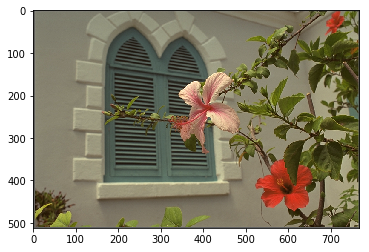

In [2]:
im = cv2.imread("./kodim07.png") #3.6 MB

shape = im.shape
print(shape)
h = shape[0]
w = shape[1]

im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.show()

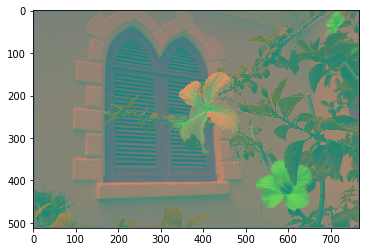

In [3]:
ycc = cv2.cvtColor(im,cv2.COLOR_RGB2YCrCb);
plt.imshow(ycc)
plt.show()

In [4]:
#JPEG algo splits image into 8x8 blocks, so we need to crop to dimensions divisible by 8
hmax = h - (h%8)
wmax = w - (w%8)
ycc = ycc[:hmax,:wmax,:]

print(ycc.shape)

cropped = im[:hmax,:wmax,:]
cv2.imwrite("./kodim07_cropped.png",cropped)

(512, 768, 3)


True

Now process the image:

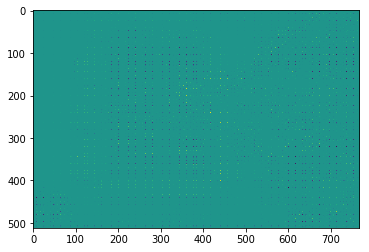

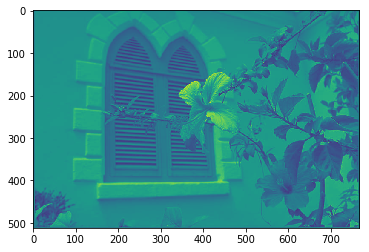

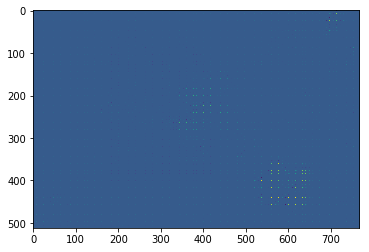

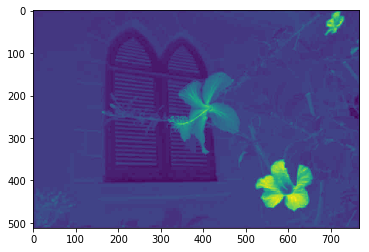

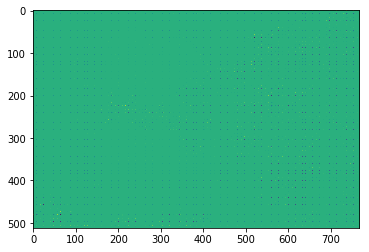

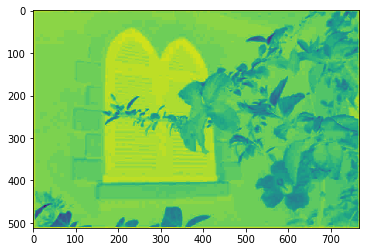

In [6]:
#transform each of the Y, Cr, and Cb spaces separately
final = np.zeros((hmax,wmax,3),np.uint8)
Q = Q*1 #scale Q to increase compression
size = 0 #estimated space needed to store compressed image, to calculate compression ratio

for k in range(3):
    
    start = np.array(ycc[:,:,k])
    start = start - float(128) #shift pixel values from [0,256] to [-128,127] to reduce range requirements for DCT processing
    compressed = np.zeros((hmax,wmax)) #initialize a matrix to piece blocks back together
    
    for i in range(int(hmax/8)):
        for j in range(int(wmax/8)):
            block = start[8*i:8*(i+1), 8*j:8*(j+1)] #eg blocks go from [0,7],[8,15],[16,23],...
            D = T @ block @ T.T #DCT on block
            C = D/Q #divide by quantization matrix...highest frequencies will be made smallest 
            C = np.round(C) #round to integer pixel values (lossy step)
            
            #JPEG can use many different complex encoding techniques
            #for our purposes, we estimate compressed image size with a simple "encoding" techinque
            #where all trailing zeros are represented with 2 bytes
            flat_C = np.reshape(np.copy(C),-1) #flatten array
            reduced_C = np.trim_zeros(flat_C)
            size += len(reduced_C) + 2 #"encode" all the zero elements
            
            compressed[8*i:8*(i+1), 8*j:8*(j+1)] = C
                 
    #decompress image and run inverse fourier transform
    plt.imshow(compressed)
    plt.show()
    
    decompressed = np.zeros((hmax,wmax))
    for i in range(int(hmax/8)):
        for j in range(int(wmax/8)):
            block = compressed[8*i:8*(i+1), 8*j:8*(j+1)]
            C = block * Q #piecewise multiply by quantization matrix
            D_inv = T.T @ C @ T #writing as matrix multiplication makes taking the inverse DCT easy
            decompressed[8*i:8*(i+1), 8*j:8*(j+1)] = D_inv
    
    decompressed = decompressed + float(128)
    decompressed = decompressed.astype(int)
    
    plt.imshow(decompressed)
    plt.show()
    
    final[:,:,k] = decompressed

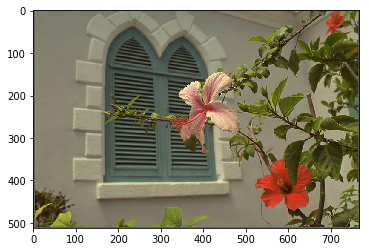

In [7]:
final_bgr = cv2.cvtColor(final,cv2.COLOR_YCrCb2BGR);
cv2.imwrite("./kodim07_1_jpg.png",final_bgr) 

final_rgb = cv2.cvtColor(final_bgr,cv2.COLOR_BGR2RGB);
plt.imshow(final_rgb)
plt.show()

We can also estimate the compression ratio, using the method described above:

In [8]:
original = ycc.shape[0] * ycc.shape[1] * ycc.shape[2]
cr = original/size
print(cr)

5.028551941685494
